In [4]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import clear_output

In [5]:
img = Image.open('pigs.jpg').convert('LA')
img = np.array(img)

In [6]:
size = (32,32)
cimg = img[:500,350:850][:,:,0]
crimg = Image.fromarray(cimg).resize(size)
crimg = np.array(crimg, dtype=float)/256
crimg.shape

(32, 32)

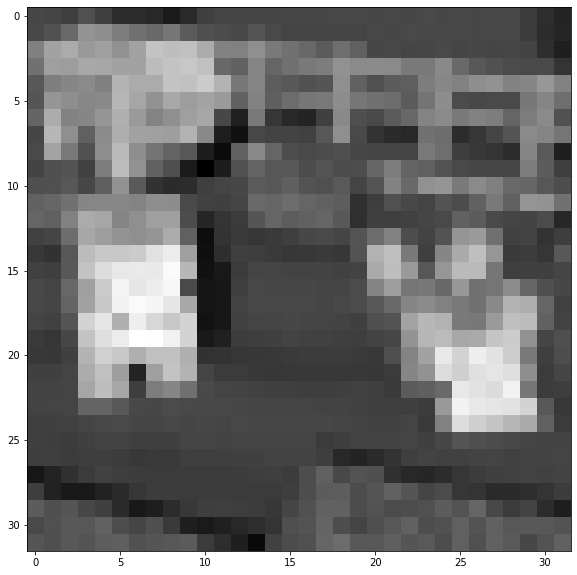

In [7]:
plt.figure(figsize=(10,10))
plt.imshow(crimg, 'gray')

# Theory
Image graph partitionong.
1. Find weights for all edges using (18) and build the
L matrix (7).
2. Choose the node of largest degree as the ground node, $v_g$,and determine $L_0$ and $d_0$ by eliminating the row/column corresponding to $v_g$.
3. Solve (13) for $x_0$.
4. Threshold the potentials x at the value that gives partitions
corresponding to the lowest isoperimetric ratio.
5. Continue recursion on each segment until the isoperimetric
ratio of the subpartitions is larger than the *stop* parameter.

**18:** $w_{ij} = exp(-\beta(I_i - I_j)^2)$  
**7:** $L_{v_i v_j} = \left\{
    \begin{array}{lr}
        d_i & if i == j\\
        -w(e_{ij}) & if e_{ij} \in E\\
        0 & otherwise
    \end{array}
\right.
$  

**13:** $L_0x_0 = d_0$

# Ideas for speedup
- Using hilbert curves for image unfoldong
- Using kernel method to compute W?

## Step 1

In [8]:
# Init image
N = crimg.shape[0] * crimg.shape[1] 

flat_img = crimg.flatten()

In [9]:
# a = np.arange(32).reshape(-1,1)
# a.repeat(32,1).flatten('F')
# flat_img_pos = np.zeros((flat_img.size,3))
# flat_img_pos[:,0] = flat_img
# flat_img_pos[:,1] = np.arange(32).reshape(-1,1).repeat(32,1).flatten('C') * 1e-6
# flat_img_pos[:,2] = np.arange(32).reshape(-1,1).repeat(32,1).flatten('F') * 1e-6

# i = 0
# j = 14
# ((flat_img_pos[i] - flat_img_pos[j])**2)

In [10]:
# Calculating graph weights
beta = 95
W = np.zeros((N,N), dtype='float')

for i in range(N):
    clear_output(wait=True)
    print(f'[{i}/{N}]')
    
    for j in range(N):
        W[i,j] = np.exp(-beta * (flat_img[i] - flat_img[j])**2)
#         W[i,j] = np.exp(-beta * ((flat_img_pos[i] - flat_img_pos[j])**2).sum())
#         W[i,j] = np.exp(-beta*((flat_img_pos[i] - flat_img_pos[j])**2).sum())

[1023/1024]


In [11]:
# np.dot(flat_img, flat_img)
# np.matmul(flat_img,flat_img)
kbeta = 95
kW = np.dot(flat_img.reshape(-1,1), flat_img.reshape(1,-1))
kW = np.exp(-kbeta*kW**2)

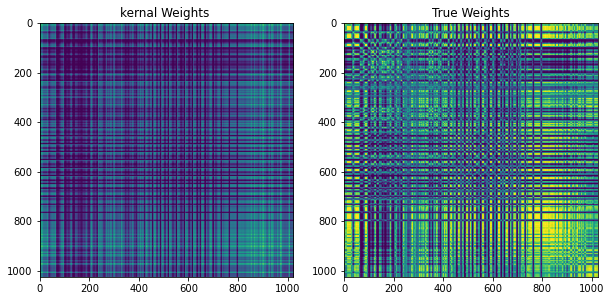

In [12]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].set_title('kernal Weights ')
ax[0].imshow(kW, vmin=0, vmax=1)

ax[1].set_title('True Weights')
ax[1].imshow(W)#, vmin=0, vmax=1)
plt.show()
# W = kW

In [13]:
# calculating graph degree
D = np.zeros(N)

for i in range(N):
    # - W[i,i] because pixel are not connected to itself
    D[i] = W[i].sum() - W[i,i]


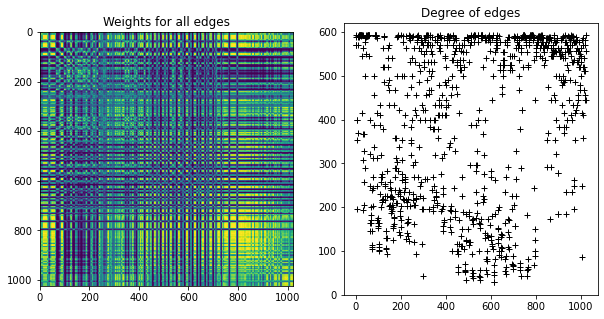

In [14]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].set_title('Weights for all edges')
ax[0].imshow(W)

ax[1].set_title('Degree of edges')
ax[1].plot(D, 'k+')
# ax[1].set_yscale('log')
plt.show()

## Step 2
2. Choose the node of largest degree as the ground node, $v_g$,and determine $L_0$ and $d_0$ by eliminating the row/column corresponding to $v_g$.


In [15]:
# Determent ground node
ground_node = D.argmax()

print(f'Ground node: {ground_node}')

Ground node: 0


In [34]:
''' V1 '''
# # Eluminate row/column of ground node
# new_W =  np.concatenate((
#     np.concatenate((
#         W[:ground_node,   :ground_node],
#         W[:ground_node,    ground_node+1:]),1),

#     np.concatenate((
#         W[ground_node+1:, :ground_node],
#         W[ground_node+1:,  ground_node+1:]), 1)))
# new_D = np.concatenate((D[:ground_node], D[ground_node+1:]))
# print(new_D.shape, new_W.shape)

# # Compute L

# L = -1 * new_W.copy()

# for i in range(new_D.size):
#     L[i,i] = new_D[i]


' V1 '

In [16]:
ground_node

0

In [17]:
''' V2 '''
L = -1 * W.copy()

for i in range(D.size):
    L[i,i] = D[i]
    
L =  np.concatenate((
    np.concatenate((
        L[:ground_node,   :ground_node],
        L[:ground_node,    ground_node+1:]),1),

    np.concatenate((
        L[ground_node+1:, :ground_node],
        L[ground_node+1:,  ground_node+1:]), 1)))
    
D0 = np.concatenate((D[:ground_node], D[ground_node+1:]))


## Step 3

In [18]:
x = np.linalg.solve(L,D0)


(1023,)


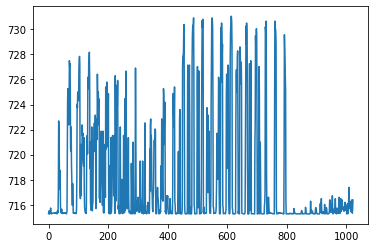

In [19]:
print(x.shape)
plt.plot(x)

## Step 4

In [20]:
new_x = np.zeros(N)
new_x[:ground_node] = x[:ground_node]
new_x[ground_node+1:] = x[ground_node:]
new_x.shape

(1024,)

In [21]:
xmin = x.min()
xmax = x.max()
step = 0.01
xmin, xmax

(715.2657997860395, 731.0464126117885)

In [24]:
# Compute Isometric ratio
# find threshold that gives lowest Isometric ratio

# Sum of weights of edges on bounady between sets

xmin = x.min()
xmax = x.max()
step = 0.5

all_th = np.arange(xmin+step,xmax,step)

lower_th = None
lower_IR = 1

# for each potential threshold
for th in np.arange(xmin+step,xmax,step):
    dS = 0
    Vol_S = 0
    
    # A - inside set; B - outside set
    set_A = x >= th
    set_B = x < th
    
    
    for a_idx in np.where(set_A)[0]:
        # Compute inside set volume
        Vol_S += D[a_idx]
        
        for b_idx in np.where(set_B)[0]:
            # Compute boundaey betwen inside and outside sets
#             print(a_idx, b_idx)
            dS += W[a_idx, b_idx]
    # Compute isometric ratio
    h_G = dS / Vol_S
    
    if h_G < lower_IR:
        lower_IR = h_G
        lower_th = th
    
#     print('[{:4d}|{:4d}] Threshold: {:2.5f} dS: {:.2f} VolS: {:.2f} Isometric ratio: {:4.5f} '.format(set_A.sum(), set_B.sum(), th, dS, Vol_S, h_G))
#     break
print(lower_IR, lower_th)

[ 442| 581] Threshold: 715.76580 dS: 64439.00 VolS: 125600.10 Isometric ratio: 0.51305 
[ 384| 639] Threshold: 716.26580 dS: 54606.95 VolS: 101632.02 Isometric ratio: 0.53730 
[ 336| 687] Threshold: 716.76580 dS: 45947.49 VolS: 82142.48 Isometric ratio: 0.55936 
[ 318| 705] Threshold: 717.26580 dS: 43035.51 VolS: 75430.52 Isometric ratio: 0.57053 
[ 308| 715] Threshold: 717.76580 dS: 40927.42 VolS: 71372.31 Isometric ratio: 0.57344 
[ 296| 727] Threshold: 718.26580 dS: 40046.28 VolS: 68084.02 Isometric ratio: 0.58819 
[ 286| 737] Threshold: 718.76580 dS: 39490.05 VolS: 65548.06 Isometric ratio: 0.60246 
[ 278| 745] Threshold: 719.26580 dS: 38329.84 VolS: 63054.01 Isometric ratio: 0.60789 
[ 258| 765] Threshold: 719.76580 dS: 35494.97 VolS: 56804.56 Isometric ratio: 0.62486 
[ 247| 776] Threshold: 720.26580 dS: 33596.06 VolS: 53241.04 Isometric ratio: 0.63102 
[ 236| 787] Threshold: 720.76580 dS: 31693.42 VolS: 49629.95 Isometric ratio: 0.63859 
[ 218| 805] Threshold: 721.26580 dS: 2869

In [72]:
mask_1 = crimg.flatten()[new_x>0]
mask_2 = crimg.flatten()[new_x<0]

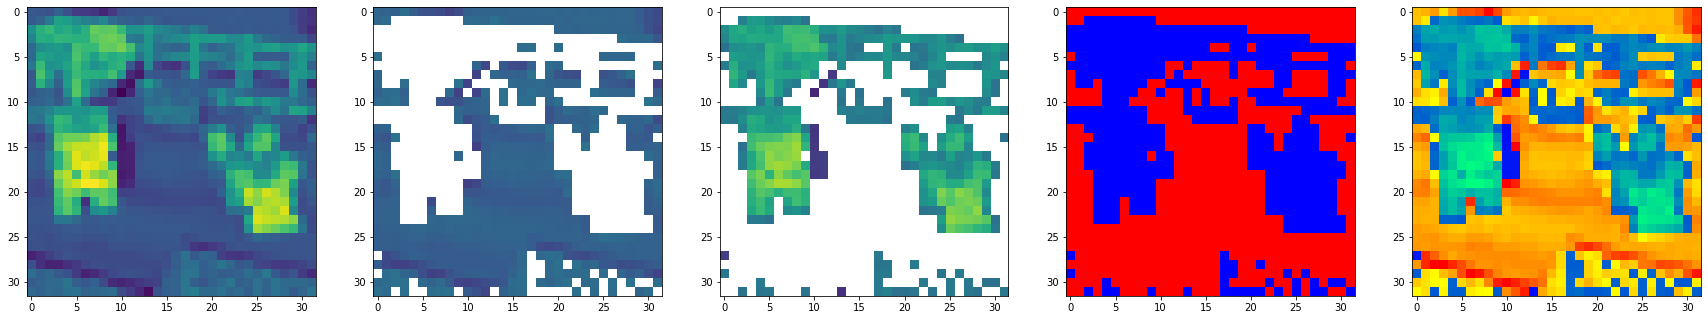

In [27]:
# mask_1.reshape(32,32)

# threshold =  all_th[60]
threshold = lower_th

rnew_x = new_x.reshape(size)

fig,ax = plt.subplots(1,5,figsize=(30,10))

ax[0].imshow(crimg)
ax[1].imshow(np.ma.masked_where(rnew_x >= threshold, crimg), vmin=0, vmax=1)
ax[2].imshow(np.ma.masked_where(rnew_x < threshold, crimg), vmin=0, vmax=1)

ax[3].imshow(np.ma.masked_where(rnew_x >= threshold, rnew_x >= threshold), 'autumn')
ax[3].imshow(np.ma.masked_where(rnew_x < threshold, rnew_x < threshold), 'winter')

ax[4].imshow(np.ma.masked_where(rnew_x > threshold, crimg), 'autumn')
ax[4].imshow(np.ma.masked_where(rnew_x < threshold, crimg), 'winter')
fig.show()